In [228]:
import pandas as pd
import time
from datetime import datetime
from pandas import ExcelWriter 
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
sns.set()

pd.__version__




'1.2.3'

In [ ]:
# temp=1588744463872/1000
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(temp))

In [119]:
temp=1588744479826/1000
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(temp))

'2020-05-06 13:54:39'

In [120]:
    # Total number of seconds between dates

In [252]:
class JTLReader:
    def __init__(self,jtlPath):
        self.jtlPath=jtlPath
        self.jtlColumns = ['timeStamp', 'elapsed','label','threadName','dataType','bytes','sentBytes','URL','allThreads','success','responseCode','responseMessage']
        self.df_Jtl=pd.read_csv(self.jtlPath,usecols=self.jtlColumns,dtype={'label':'category'})#dtype={'label':'category'},nrows=195222    
        self.df_Jtl.sort_values(by=['timeStamp'],inplace=True) 
        self.df_Jtl.reset_index(drop=True, inplace=True)
        self.shape=self.df_Jtl.shape
        self.rows=self.shape[0]
        self.rows
        """Conver Epoc time to Actual Time Start"""
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'],unit='ms')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')#reduce precision pandas timestamp dataframe
        self.df_Jtl['timeStamp']=self.df_Jtl['timeStamp'].dt.tz_localize('utc').dt.tz_convert('Singapore')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype(str).str[:-6]
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'])
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')
        """Conver Epoc time to Actual Time End"""
        
        """Filtering Subscriber Txn"""
        #self.filt_Subscriber=(self.df_Jtl['label']=='iBORDETS_Subscribers')
        #self.df_Jtl=self.df_Jtl.loc[~self.filt_Subscriber]
        """Saving master data frame to export to excel"""
        
        
        """Filter Transaction Controller & HTTP Request"""
        self.filt=(pd.isnull(self.df_Jtl['URL'])) #& (pd.isnull(self.df_Jtl['dataType']))
        self.df_jtl_TC=self.df_Jtl.loc[self.filt]
        self.df_jtl_HTTPReqeust=self.df_Jtl.loc[~self.filt]
        """Error Handling To be updated"""
        self.error_filt=(self.df_jtl_HTTPReqeust['success']==False) | (self.df_jtl_HTTPReqeust['success']==True)
        self.df_HttpErrors=self.df_jtl_HTTPReqeust.loc[self.error_filt]      
          
              
        
    """def getTransactionControllerData(self):
        print("Hello shiva")
        filt=(pd.isnull(self.df_Jtl['URL'])) & (pd.isnull(self.df_Jtl['dataType']))
        self.df_jtl_TC=self.df_Jtl.loc[filt]
        return self.df_jtl_TC"""
        

        
    def converTimeStamp(self):
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'],unit='ms')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')#reduce precision pandas timestamp dataframe
        self.df_Jtl['timeStamp']=self.df_Jtl['timeStamp'].dt.tz_localize('utc').dt.tz_convert('Africa/Cairo')#Africa/Cairo
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype(str).str[:-6]
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'])
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]') 
        
    def ms_to_sec(self):
         self.df_Jtl['elapsed']=((self.df_Jtl['elapsed'])/1000)
        
        
    def overAllResponseTimeSummary(self):
        self.df_overAllResponseTimeSummary=self.df_jtl_TC[['timeStamp','elapsed']]
        return self.df_overAllResponseTimeSummary
       
    def listOfErrors(self):
        return self.df_Jtl['responseCode'].value_counts()
    
    def shapeOfDaraFrame(self):
        return self.df_Jtl.shape
    
    def columnType(self,columnName):
        self.columnName=columnName
        return self.df_Jtl[self.columnName].dtype
    
    def getPeriod(self):
        self.startTime=self.df_Jtl['timeStamp'][0]
        self.endRow=self.df_Jtl['timeStamp'].shape[0]
        self.endTime=self.df_Jtl['timeStamp'][self.endRow-1]
        return f'{self.startTime} : {self.endTime}'
    
    def getDuration(self):
        self.startTime= self.df_Jtl['timeStamp'][0]
        self.endRow= self.df_Jtl['timeStamp'].shape[0]
        self.endTime= self.df_Jtl['timeStamp'][self.endRow-1]#-1
        self.executionStartTime=datetime(self.startTime.year,self.startTime.month,self.startTime.day,self.startTime.hour,self.startTime.minute,self.startTime.second)
        self.executionEndTime=datetime(self.endTime.year,self.endTime.month,self.endTime.day,self.endTime.hour,self.endTime.minute,self.endTime.second)
        self.timeDiff = self.executionEndTime-self.executionStartTime
        self.duration_in_s = self.timeDiff.total_seconds()
        self.duration=time.strftime("%H:%M:%S", time.gmtime(self.duration_in_s))
        return self.duration
    
    def getMaxRunningVusers(self):
        self.allThread=self.df_Jtl['allThreads'].max()
        return self.allThread 
    
      
    def getTotalHits(self):
        return self.df_jtl_HTTPReqeust.shape[0]
    
    def getAvgHitsPerSecond(self):
        return self.df_jtl_HTTPReqeust.shape[0]/self.duration_in_s
    
    def getTotalThroughput(self):
        self.totalThroughput=self.df_jtl_TC['bytes'].sum()
        return self.totalThroughput
    
    def getAvgThroughputPerSecond(self):
        self.avgThroughput=(self.df_jtl_TC['bytes'].sum())/self.duration_in_s
        return self.avgThroughput
    
    def getTotalPassFailFreqList(self):
        self.passFail_freq=self.df_jtl_TC['success'].value_counts().to_frame()
        #self.passFailFrequencyeqList=self.passFail_freq.index.tolist()
        
        return self.passFail_freq      
    
    def getTotalErrors(self):
        self.totalError=self.df_HttpErrors[['responseCode']].groupby(['responseCode'])
        self.totalError=self.df_HttpErrors['responseCode'].count()
        return self.totalError

    def getAnalysisSummary(self):
        self.period=self.getPeriod()
        self.duration=self.getDuration()
        self.maxRunningVusers=self.getMaxRunningVusers()
        self.totalThroughput=self.getTotalThroughput()
        self.avgThroughputPerSecond=self.getAvgThroughputPerSecond()
        self.totalHits=self.getTotalHits()
        self.avgHitsPerSecond=self.getAvgHitsPerSecond()
        self.totalErrors=self.getTotalErrors()
        self.df_AnalysisSummary=pd.DataFrame(
            {
                'Data':[
                        'Period','Duration','Maximum Running Vusers','Total bytes',
                        'Average bytes/second','TotalHits','Average Hits Per Second',
                        'Total Error','Total Pass','Total Failed'
                ],
                'Values':[
                            self.period,self.duration,self.maxRunningVusers,self.totalThroughput,
                            self.avgThroughputPerSecond,self.totalHits,self.avgHitsPerSecond,
                            self.totalErrors,self.getTotalPassFailFreqList(),'NA'
                ]
                
            }
        )
        return self.df_AnalysisSummary
    
    def responseTimeSummary(self):
        self.df_responseTimeSummary=self.df_jtl_TC[['label','elapsed']]
        self.df_txnGroup=self.df_responseTimeSummary.groupby(['label'],observed=True )  #observed=True      
        self.df_txnGroup=self.df_txnGroup['elapsed'].describe(percentiles=[.90])#self.df_txnGroup.describe(percentiles=[.90])
        self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(0)#self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(1)
        self.df_txnGroup = self.df_txnGroup[['count','min','mean','90%','max',]]
        self.df_txnGroup.rename(columns={'count':'#Samples','min':'Min','mean':'Average','90%':'90 Percentile','max':'Max'},inplace=True)
        ##self.df_txnGroup=self.df_txnErrorGroup.reset_index() """To be enable if you run describe () on data frame. Now we are running on specific column"""
        ##self.df_txnGroup['throughput']=self.df_txnGroup['count']/self.duration_in_s
        ##self.validTxn_filt=(self.df_txnGroup['count']>0)
        self.df_responseTimeSummaryOutput=self.df_txnGroup #self.df_txnGroup[self.validTxn_filt]
       
        return self.df_responseTimeSummaryOutput
    
    def getPassFailSummary(self):
        self.df_passFailSummary=self.df_jtl_TC[['label','success']]
        self.df_passFailGroup=self.df_passFailSummary.groupby(['label'],observed=True)#whe we use observed=True-->refer https://stackoverflow.com/questions/54922327/valueerror-operands-could-not-be-broadcast-together-with-shape-when-calling-pan?answertab=votes#tab-top
        self.df_txnGroup=self.df_passFailGroup['success'].value_counts()
        self.df_txnGroupSlice=self.df_txnGroup.loc[:,]
        self.df_passFailSummaryOutput=self.df_txnGroupSlice.unstack()
        self.df_passFailSummaryOutput=self.df_passFailSummaryOutput.fillna(0)
        self.df_passFailSummaryOutput.rename(columns={True:'Pass',False:'Fail'},inplace=True)
        return self.df_passFailSummaryOutput
        
    def getFinalResponseSummary(self):
        rs=pd.merge(self.df_responseTimeSummaryOutput,self.df_passFailSummaryOutput,left_index=True,right_index=True)
        if 'Fail' in rs.columns:# If transaction fail observed 
            rs['Error%']=((rs['Fail'])/(rs['#Samples']))*100 
            rs=rs[['#Samples','Pass','Fail','Error%','Min','Average','90 Percentile','Max']]#'Fail','Error%'
            return rs
        else:# All transactions pass
            rs=rs[['#Samples','Pass','Min','Average','90 Percentile','Max']]
            
            return rs
            
            
    
    def getRunnerVuserGraphData(self):
        '''T=min,S=Seconds'''       
        self.df_vusers=self.df_jtl_TC[['timeStamp','allThreads']]
        self.df_vusers.sort_values(by=['timeStamp'])
        self.df_vusers.set_index('timeStamp',inplace=True)
        self.df_vusers_summary = pd.DataFrame()
        self.df_vusers_summary['Vusers']=self.df_vusers['allThreads'].resample('10S').max()  
        self.df_vusers_summary.ffill(inplace=True)
        return self.df_vusers_summary
         
        
    
    def getHitsPersecondGraphData(self):
        '''T=min,S=Seconds'''
        #self.df_jtl_HTTPReqeust['hits']=1
        self.df_hits=self.df_jtl_HTTPReqeust[['timeStamp','URL']]#self.df_jtl_HTTPReqeust[['timeStamp','hits']]
        #self.df_hits.sort_values(by=['timeStamp'])
        self.df_hits.set_index('timeStamp',inplace=True)
        self.df_hits_summary = pd.DataFrame()
        self.df_hits_summary['hitsCount']=self.df_hits['URL'].resample('10S').count()/60   
        #df.loc[(df!=0).any(axis=1)]
        self.df_hits_summary=self.df_hits_summary.loc[(self.df_hits_summary!=0).any(axis=1)]
        return self.df_hits_summary
        #return self.df_hits
    
    def getThrouhputPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_throughput=self.df_jtl_TC[['timeStamp','bytes']]
        #self.df_throughput.sort_values(by=['timeStamp'])
        self.df_throughput.set_index('timeStamp',inplace=True)
        self.df_throughput_summary = pd.DataFrame()
        self.df_throughput_summary['ThroughputReceived']=self.df_throughput['bytes'].resample('10S').sum()/60 
        return self.df_throughput_summary.astype(int)
        
    
    def getThrouhputSendPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_throughputsend=self.df_jtl_TC[['timeStamp','sentBytes']]
        #self.df_throughputsend.sort_values(by=['timeStamp'])
        self.df_throughputsend.set_index('timeStamp',inplace=True)
        self.df_throughputsend_summary = pd.DataFrame()
        self.df_throughputsend_summary['ThroughputSend']=self.df_throughputsend['sentBytes'].resample('10S').sum()/60    
        return self.df_throughputsend_summary.astype(int)
    
    def getErrorPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_errorCode=self.df_HttpErrors[['timeStamp','responseCode']]
        #self.df_throughputsend.sort_values(by=['timeStamp'])
        self.df_errorCode.set_index('timeStamp',inplace=True)
        self.df_errorCode_summary = pd.DataFrame()
        self.df_errorCode_summary['HTTPError']=self.df_errorCode['responseCode'].resample('1T').count() 
        return self.df_errorCode_summary
    
    def gerErrorPivot(self):
        self.df_df_HttpErrors_pivot=self.df_HttpErrors[['timeStamp','responseCode','responseMessage']]
        return self.df_df_HttpErrors_pivot.pivot_table(index=pd.Grouper(freq='T',key='timeStamp'),columns="responseMessage",aggfunc="count")        
 
    
    def getOverallResponseTime(self):
        return self.df_jtl_TC[['timeStamp','elapsed','label']]
    
    def getRawDataFrame(self):
        return self.df_Jtl
    
#     def get errorSummary(self):
#         self.filt_error=(self.df_jtl_HTTPReqeust['responseCode']!=200) & (self.df_jtl_HTTPReqeust['responseCode']!=202)
#         self.df_error=self.df_jtl_HTTPReqeust[self.filt_error]
#         return self.df_error
    
    def temp(self):
        self.slicer_grp=self.df_jtl_TC[['timeStamp','elapsed','label']]
        self.slicer_grp.sort_values(by=['timeStamp'])
        self.slicer_grp.set_index('timeStamp',inplace=True)
        self.df_response_summary_slicer = pd.DataFrame()
        self.df_slicer_txnGroup=self.slicer_grp.groupby(['label'],observed=True )
        self.df_response_summary_slicer=self.df_slicer_txnGroup['elapsed'].resample('30T').agg(['min','mean','max','count'])
        return self.df_response_summary_slicer
    
    def getDetailHttpErrors(self):
        self.df_errors=self.df_HttpErrors[['timeStamp','label','responseCode','responseMessage']]
        return  self.df_errors
    
    def getHttpErrorSummary(self):
        self.df_HttpErrorSummary=self.df_HttpErrors[['responseCode','responseMessage']].groupby(['responseCode'])
        self.df_HttpErrorSummary=self.df_HttpErrors['responseCode'].value_counts()
        return self.df_HttpErrorSummary
    
    
      
obj1=JTLReader("C:\\Karthik\\02_Scripts\\Scripts_5_4_1\\Results\\02_Feb_23\\12UserLoadtest.jtl") 
#obj1.converTimeStamp()
obj1.ms_to_sec() 
obj1.getDuration()



'01:01:49'

In [122]:
#obj1.gerErrorPivot()

In [123]:
#obj1.getHttpErrorSummary()

In [124]:
#y=obj1.getTotalPassFailFreqList()
#y

In [125]:
#x=obj1.temp()
#x

In [126]:
#obj1.df_Jtl

In [127]:
#obj1.df_jtl_HTTPReqeust

In [128]:
#obj1.df_jtl_TC

In [129]:
#obj1.getPeriod()

In [130]:
#obj1.getDuration()

In [131]:
#obj1.getMaxRunningVusers()

In [132]:
#obj1.getTotalThroughput()

In [253]:
"""Analysis Summery"""
analysisSummary=obj1.getAnalysisSummary()
analysisSummary


,Data,Values
0,Period,2021-02-23 15:15:25 : 2021-02-23 16:17:14
1,Duration,01:01:49
2,Maximum Running Vusers,12
3,Total bytes,2007381012
4,Average bytes/second,541218.93017
5,TotalHits,9242
6,Average Hits Per Second,2.491777
7,Total Error,9242
8,Total Pass,success True 2391 False 3
9,Total Failed,NA


In [254]:
"""responseTimeSummary"""
responseTimeSummary=obj1.responseTimeSummary()
responseTimeSummary

,#Samples,Min,Average,90 Percentile,Max
label,,,,,
001_ISMSAccessURL,28.0,2851.0,3624.642857,5249.9,9137.0
002_ISMSLogin,28.0,4447.0,4875.285714,5078.0,7075.0
ISMS_BP01_WL_SearchIncidentByID_TX01_IncidentMonitoring,49.0,321.0,5433.979592,10643.2,11605.0
ISMS_BP01_TU_SearchIncidentByID_TX01_IncidentMonitoring,49.0,330.0,5330.530612,10314.6,11413.0
ISMS_BP01_WL_SearchIncidentByID_TX02_SearchIncidentByID,49.0,97.0,2051.204082,3751.4,4381.0
...,...,...,...,...,...
BP01_WL_TX03_WL_ChooseFile,17.0,36.0,51.411765,59.4,63.0
BP01_WL_TX04_ClickOnCreate,17.0,13282.0,81035.470588,139086.6,141838.0
BP01_TU_Tx05_EnterRemart_Close,20.0,7420.0,44324.900000,81512.5,88739.0


In [255]:
"""Get Pass and Fail Summary"""
passandfail=obj1.getPassFailSummary()
passandfail

success,Fail,Pass
label,,
001_ISMSAccessURL,0.0,28.0
002_ISMSLogin,0.0,28.0
ISMS_BP01_WL_SearchIncidentByID_TX01_IncidentMonitoring,0.0,49.0
ISMS_BP01_TU_SearchIncidentByID_TX01_IncidentMonitoring,0.0,49.0
ISMS_BP01_WL_SearchIncidentByID_TX02_SearchIncidentByID,0.0,49.0
...,...,...
BP01_WL_TX03_WL_ChooseFile,0.0,17.0
BP01_WL_TX04_ClickOnCreate,1.0,16.0
BP01_TU_Tx05_EnterRemart_Close,1.0,19.0


In [256]:
"""Get Final Response Summary"""
rs=obj1.getFinalResponseSummary()
rs

,#Samples,Pass,Fail,Error%,Min,Average,90 Percentile,Max
label,,,,,,,,
001_ISMSAccessURL,28.0,28.0,0.0,0.000000,2851.0,3624.642857,5249.9,9137.0
002_ISMSLogin,28.0,28.0,0.0,0.000000,4447.0,4875.285714,5078.0,7075.0
ISMS_BP01_WL_SearchIncidentByID_TX01_IncidentMonitoring,49.0,49.0,0.0,0.000000,321.0,5433.979592,10643.2,11605.0
ISMS_BP01_TU_SearchIncidentByID_TX01_IncidentMonitoring,49.0,49.0,0.0,0.000000,330.0,5330.530612,10314.6,11413.0
ISMS_BP01_WL_SearchIncidentByID_TX02_SearchIncidentByID,49.0,49.0,0.0,0.000000,97.0,2051.204082,3751.4,4381.0
...,...,...,...,...,...,...,...,...
BP01_WL_TX03_WL_ChooseFile,17.0,17.0,0.0,0.000000,36.0,51.411765,59.4,63.0
BP01_WL_TX04_ClickOnCreate,17.0,16.0,1.0,5.882353,13282.0,81035.470588,139086.6,141838.0
BP01_TU_Tx05_EnterRemart_Close,20.0,19.0,1.0,5.000000,7420.0,44324.900000,81512.5,88739.0


In [257]:
"""Get Vuser Summary"""
runningVuser=obj1.getRunnerVuserGraphData()
runningVuser

,Vusers
timeStamp,
2021-02-23 15:15:20,2.0
2021-02-23 15:15:30,3.0
2021-02-23 15:15:40,4.0
2021-02-23 15:15:50,5.0
2021-02-23 15:16:00,6.0
...,...
2021-02-23 16:16:00,7.0
2021-02-23 16:16:10,7.0
2021-02-23 16:16:20,7.0


In [258]:
"""Get Hits Summary"""
hitsPersecond=obj1.getHitsPersecondGraphData() 
hitsPersecond

,hitsCount
timeStamp,
2021-02-23 15:15:20,0.016667
2021-02-23 15:15:30,0.016667
2021-02-23 15:15:40,0.183333
2021-02-23 15:15:50,0.483333
2021-02-23 15:16:00,0.233333
...,...
2021-02-23 16:16:30,0.116667
2021-02-23 16:16:40,0.183333
2021-02-23 16:16:50,0.066667


In [259]:
"""Get Throughput Received Summery"""
throughput=obj1.getThrouhputPersecondGraphData()
throughput

,ThroughputReceived
timeStamp,
2021-02-23 15:15:20,547493
2021-02-23 15:15:30,547493
2021-02-23 15:15:40,548468
2021-02-23 15:15:50,549210
2021-02-23 15:16:00,548613
...,...
2021-02-23 16:16:00,10566
2021-02-23 16:16:10,85
2021-02-23 16:16:20,1893


In [260]:
"""Get Throughput Send Summery"""
throughputsend=obj1.getThrouhputSendPersecondGraphData()
throughputsend

,ThroughputSend
timeStamp,
2021-02-23 15:15:20,138
2021-02-23 15:15:30,138
2021-02-23 15:15:40,868
2021-02-23 15:15:50,1109
2021-02-23 15:16:00,873
...,...
2021-02-23 16:16:00,546
2021-02-23 16:16:10,699
2021-02-23 16:16:20,1341


In [261]:
"""Get Error Summary"""
errors=obj1.getErrorPersecondGraphData()
errors

,HTTPError
timeStamp,
2021-02-23 15:15:00,42
2021-02-23 15:16:00,245
2021-02-23 15:17:00,419
2021-02-23 15:18:00,408
2021-02-23 15:19:00,347
...,...
2021-02-23 16:13:00,71
2021-02-23 16:14:00,126
2021-02-23 16:15:00,113


In [262]:
"""overAllResponseTimeSummary"""
overallResponseTime=obj1.getOverallResponseTime()
overallResponseTime

,timeStamp,elapsed,label
0,2021-02-23 15:15:25,9137,001_ISMSAccessURL
2,2021-02-23 15:15:35,5090,001_ISMSAccessURL
11,2021-02-23 15:15:45,7075,002_ISMSLogin
12,2021-02-23 15:15:45,4697,001_ISMSAccessURL
13,2021-02-23 15:15:46,6072,002_ISMSLogin
...,...,...,...
11611,2021-02-23 16:16:35,2058,ISMS_BP05_TU_SearchIncidentBySeverity_TX03_Sea...
11612,2021-02-23 16:16:39,1333,ISMS_BP05_SearchIncidentBySeverity_TX03_Search...
11615,2021-02-23 16:16:42,5872,ISMS_BP05_TU_SearchIncidentBySeverity_TX04_Vie...
11620,2021-02-23 16:16:44,22851,BP01_TU_Tx05_EnterRemart_Close


In [263]:
detailerrors=obj1.getDetailHttpErrors()
detailerrors

,timeStamp,label,responseCode,responseMessage
1,2021-02-23 15:15:25,001_ISMSAccessURL-0,200.0,OK
3,2021-02-23 15:15:35,001_ISMSAccessURL-0,200.0,OK
4,2021-02-23 15:15:40,001_ISMSAccessURL-1,200.0,OK
5,2021-02-23 15:15:40,001_ISMSAccessURL-2,200.0,NaN
6,2021-02-23 15:15:40,001_ISMSAccessURL-3,200.0,NaN
...,...,...,...,...
11631,2021-02-23 16:16:52,ISMS_BP05_SearchIncidentBySeverity_TX04_ViewIn...,200.0,OK
11632,2021-02-23 16:17:03,BP01_WL_TX04_ClickOnCreate-06,200.0,OK
11633,2021-02-23 16:17:04,BP01_TU_Tx05_EnterRemart_Close-2,200.0,OK
11634,2021-02-23 16:17:06,BP01_WL_TX04_ClickOnCreate-07,200.0,OK


In [264]:
errorPivot=obj1.gerErrorPivot()

In [265]:
obj1.getHttpErrorSummary()

200.0    8925
202.0     314
504.0       3
Name: responseCode, dtype: int64

In [266]:
rawdataframe=obj1.getRawDataFrame()
rawdataframe

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,bytes,sentBytes,allThreads,URL
0,2021-02-23 15:15:25,9.137,001_ISMSAccessURL,200.0,"Number of samples in transaction : 4, number o...",ISMS_BP01_TU_SearchIncidentByID 1-1,NaN,True,32849636,8280,2,NaN
1,2021-02-23 15:15:25,8.943,001_ISMSAccessURL-0,200.0,OK,ISMS_BP01_TU_SearchIncidentByID 1-1,text,True,32841968,6895,1,https://icon.internal.local/login
2,2021-02-23 15:15:35,5.090,001_ISMSAccessURL,200.0,"Number of samples in transaction : 4, number o...",ISMS_BP01_WL_SearchIncidentByID 2-1,NaN,True,32849636,8280,3,NaN
3,2021-02-23 15:15:35,4.964,001_ISMSAccessURL-0,200.0,OK,ISMS_BP01_WL_SearchIncidentByID 2-1,text,True,32841968,6895,2,https://icon.internal.local/login
4,2021-02-23 15:15:40,0.106,001_ISMSAccessURL-1,200.0,OK,ISMS_BP01_TU_SearchIncidentByID 1-1,text,True,664,455,2,https://icon.internal.local/assets/json/config...
...,...,...,...,...,...,...,...,...,...,...,...,...
11631,2021-02-23 16:16:52,4.010,ISMS_BP05_SearchIncidentBySeverity_TX04_ViewIn...,200.0,OK,ISMS_BP05_WL_SearchIncidentBySeverity 10-1,text,True,170,3521,3,https://icon.internal.local/ECHO/ims/v0/WL/inc...
11632,2021-02-23 16:17:03,3.496,BP01_WL_TX04_ClickOnCreate-06,200.0,OK,ISMS_BP06_WL_CreateManualIncident 12-1,text,True,170,3521,2,https://icon.internal.local/ECHO/ims/v0/WL/inc...
11633,2021-02-23 16:17:04,3.202,BP01_TU_Tx05_EnterRemart_Close-2,200.0,OK,ISMS_BP06_TU_CreateManualIncident 11-1,text,True,170,3521,2,https://icon.internal.local/ECHO/ims/v0/TU/inc...
11634,2021-02-23 16:17:06,2.735,BP01_WL_TX04_ClickOnCreate-07,200.0,OK,ISMS_BP06_WL_CreateManualIncident 12-1,text,True,2171,3508,1,https://icon.internal.local/ECHO/rms/v0/resour...


In [267]:
"""Generate Excel Report"""
writer = ExcelWriter('PerformanceTestReport.xlsx',mode='w')
#Write Analysis Summary to Excel
analysisSummary.to_excel(writer,sheet_name='AnalysisSummary')
#write response summary to excel with txn name,min,avg,max,90% & max
rs.to_excel(writer,sheet_name='ResponseSummary')
#Write Running Vusers
runningVuser.to_excel(writer,sheet_name='RunningVuserSummary')
#Write Hits Summary
hitsPersecond.to_excel(writer,sheet_name='HitsSummary')
#Write Throughput Received Summary
throughput.to_excel(writer,sheet_name='ThroughputReceivedSummary')
#Write Throughput Send Summary
throughputsend.to_excel(writer,sheet_name='ThroughputSendSummary')
#Write error summary
errors.to_excel(writer,sheet_name='ErrorGraph')
#Write ResponseTime
overallResponseTime.to_excel(writer,sheet_name='ResponseTimeGraph')
#Write Detail Errors
detailerrors.to_excel(writer,sheet_name='DetailErrors')
#Write Error Pivot
errorPivot.to_excel(writer,sheet_name='ErrorPivot')
#Export Original dataframe
rawdataframe.to_excel(writer,sheet_name='dataframe')
writer.save()







#Draw Running Vuser Graph

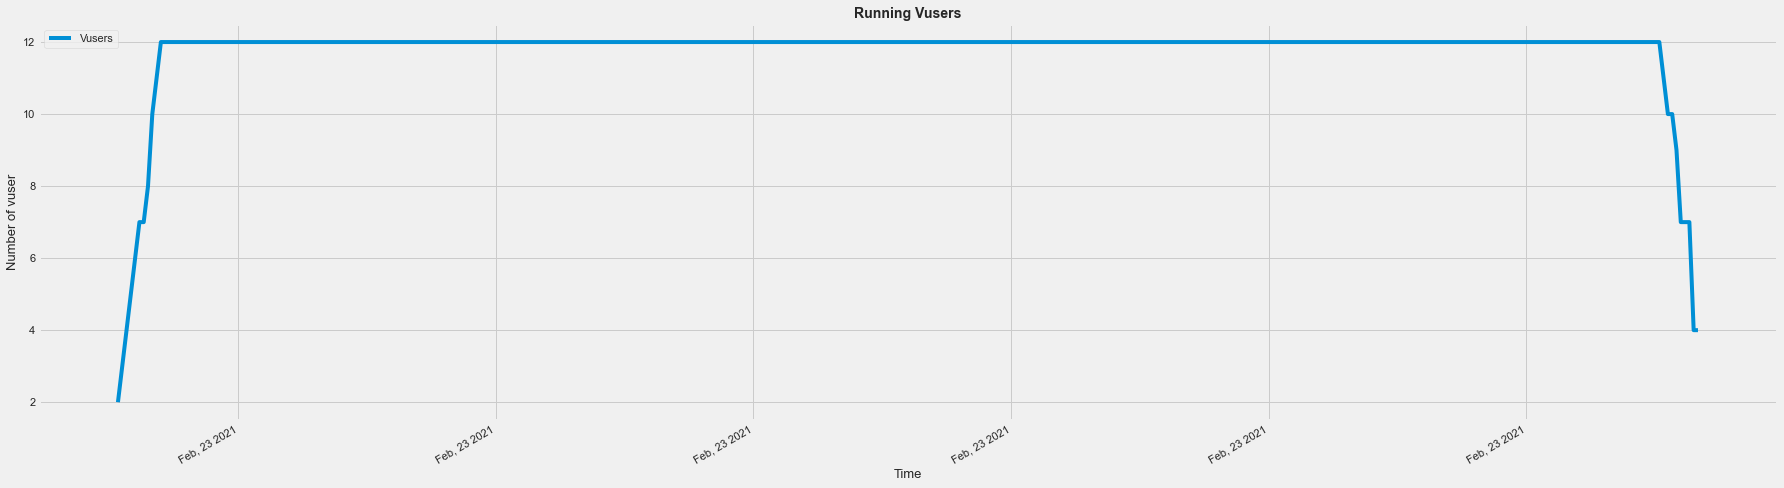

In [268]:
df_vuser=obj1.getRunnerVuserGraphData()
df_vuser.reset_index('timeStamp',inplace=True)
#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_vuser['timeStamp'],df_vuser['Vusers'],label='Vusers')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Running Vusers",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13)#,fontweight="bold"
plt.ylabel("Number of vuser",fontsize=13)#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()
#plt.savefig("Vuser.png")


In [ ]:
#Draw Hits Summary

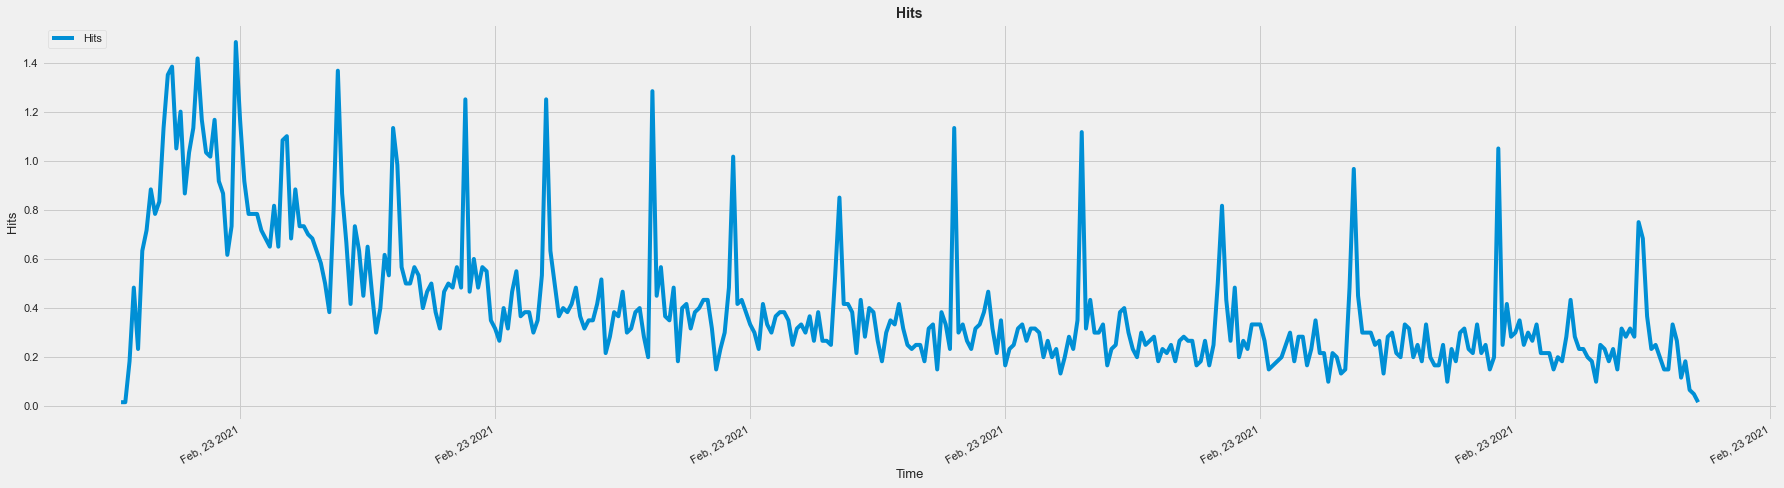

In [269]:
df_hits=obj1.getHitsPersecondGraphData()
df_hits.reset_index('timeStamp',inplace=True)
#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_hits['timeStamp'],df_hits['hitsCount'],label='Hits')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Hits",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13)#,fontweight="bold"
plt.ylabel("Hits",fontsize=13)#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()
#plt.savefig("Vuser.png")

In [ ]:
#Draw Throughput Received

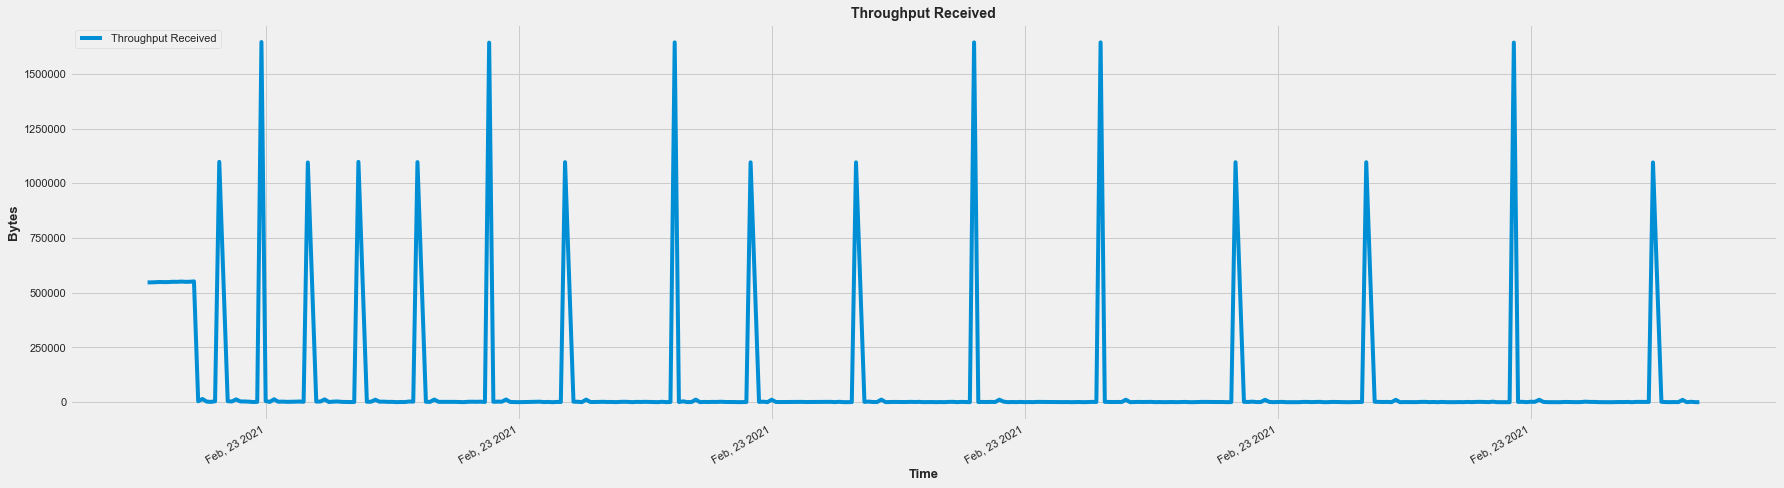

In [270]:
df_throughput=obj1.getThrouhputPersecondGraphData()
df_throughput.reset_index('timeStamp',inplace=True)


#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_throughput['timeStamp'],df_throughput['ThroughputReceived'],label='Throughput Received')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Throughput Received",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Bytes",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()


In [ ]:
#Draw Throughput Send

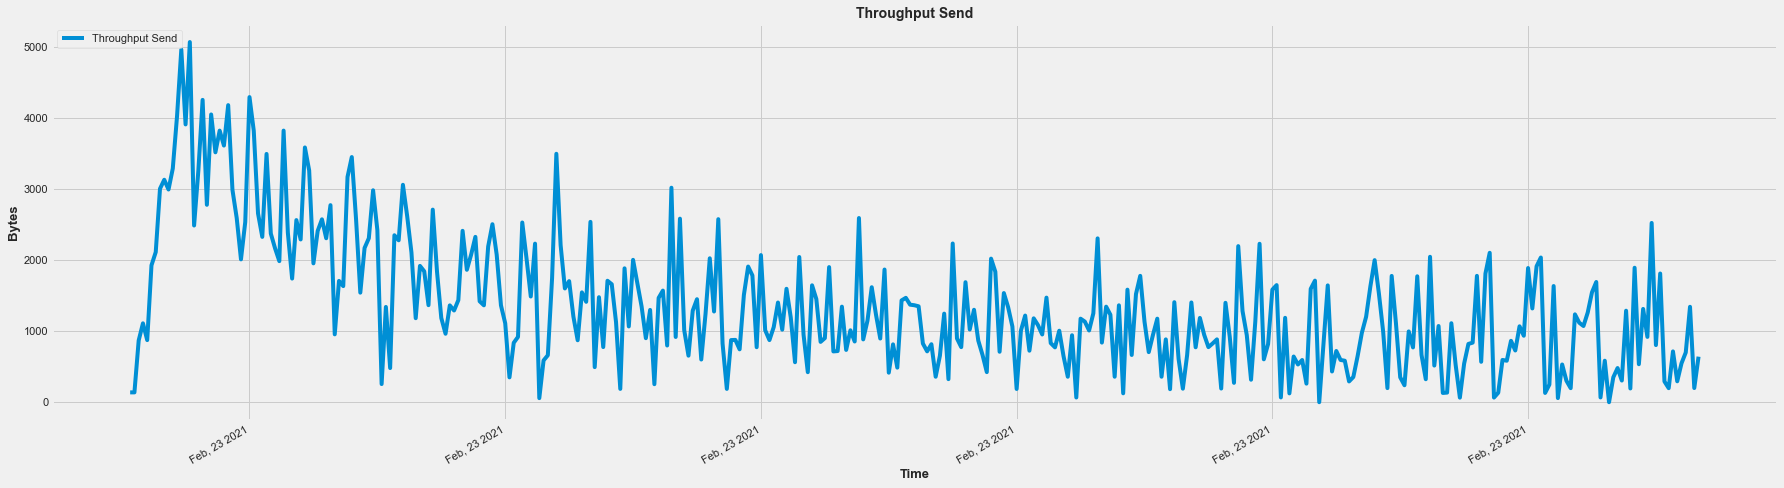

In [272]:
df_throughput_send=obj1.getThrouhputSendPersecondGraphData()
df_throughput_send.reset_index('timeStamp',inplace=True)

#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_throughput_send['timeStamp'],df_throughput_send['ThroughputSend'],label='Throughput Send')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Throughput Send",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Bytes",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()


In [ ]:
#Draw Error Grph

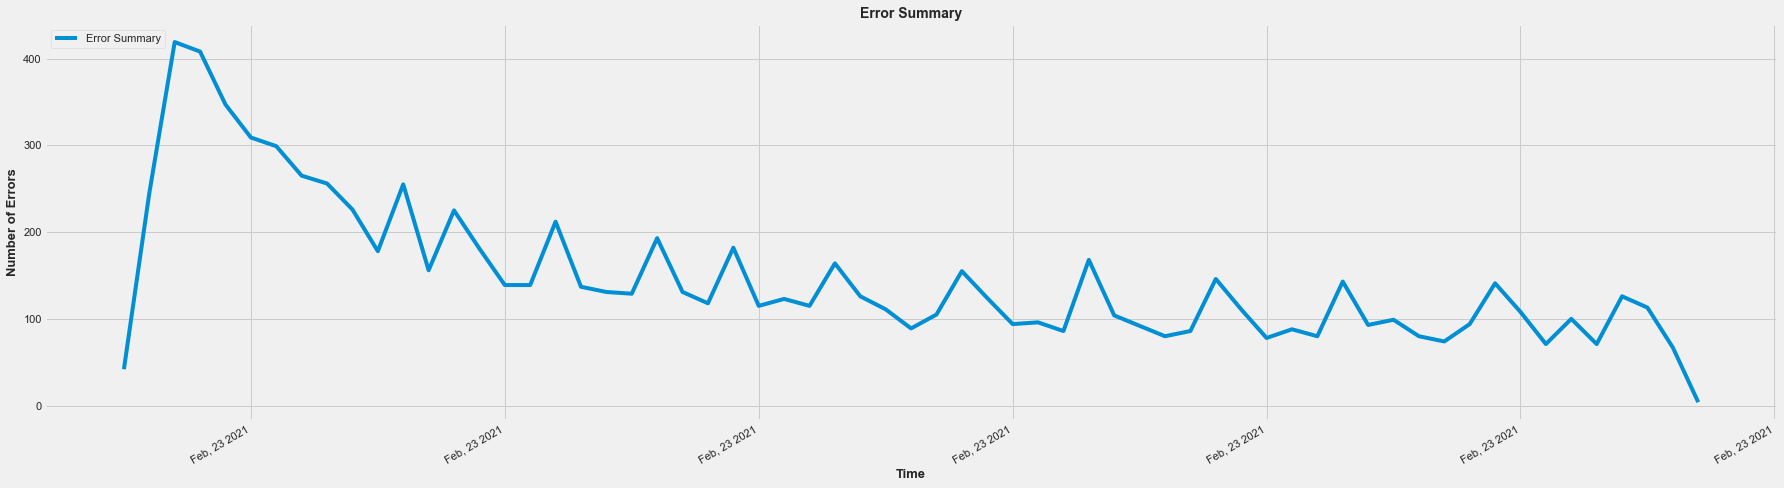

In [273]:
df_errors=obj1.getErrorPersecondGraphData()
df_errors.reset_index('timeStamp',inplace=True)

#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_errors['timeStamp'],df_errors['HTTPError'],label='Error Summary')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Error Summary",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Number of Errors",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()